In [1]:
import pandas as pd

In [19]:
df1=pd.read_csv('mean_mse100.csv').iloc[:,1:]
df2=pd.read_csv('linear_mse100.csv').iloc[:,1:]

<AxesSubplot:>

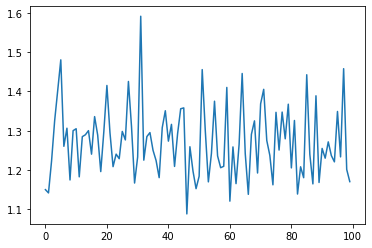

In [29]:
df1.mean(axis=1).plot()

<AxesSubplot:>

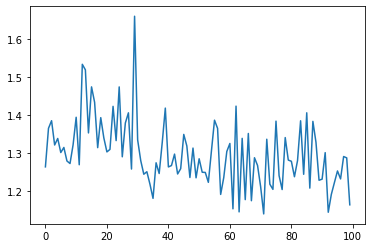

In [30]:
df2.mean(axis=1).plot()

<AxesSubplot:>

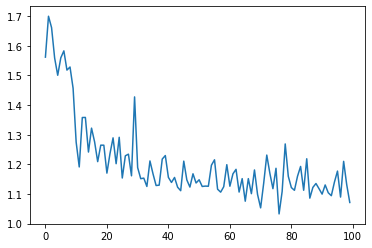

In [21]:
df2['node 2'].plot()